In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib notebook
import scipy.optimize as opt
import math
from scipy.integrate import ode
#import ObFunc

In [2]:
SSA_data = np.loadtxt("SS",dtype='float')
# The parameter vector
init_params = [48.4, 49.2, 48.4, 49.2, 48.4, 
               13.6, 1, 0.023, 48.4, 13.6, 
               0.00001, 0.00001, 0.3]
step_length = 1000
#print (init_params)
#print (SSA_data)

In [3]:
def f(t,y,P):
# A Markov state model for the rapidly activating inward rectifying potassium current (IKur)      
    V = P[-1] # For simplicity we pass voltage as a parameter (when would this be a bad idea?)
    dim = y.shape
    dy = np.zeros((dim))
    #states
    O = int(0)
    I = int(1)
    C4 = int(2)
    C3 = int(3)
    C2 = int(4)
    C1 = int(5)
    B = int(6)
    
    n = 7 # number of states
    A = np.zeros((n,n)) # initialize rate mass matrix for output

    alpha = math.exp((V-P[0])/P[1])
    beta = math.exp((V-P[2])/P[3])*math.exp(-(V+P[4])/P[5])/(P[6]+P[7]*math.exp(-(V+P[8])/P[9]))

    #calculate transitions between closed states
    A[C1, C2] = beta
    A[C2, C1] = 4*alpha
    A[C2, C3] = 2*beta
    A[C3, C2] = 3*alpha
    A[C3, C4]  = 3*beta
    A[C4, C3]  = 2*alpha
    
    #calculate transitions between closed and open states
    A[O, C4]  = alpha
    A[C4, O]  = 4*beta
    
    #calculate transitions between inactive and open states
    A[O, I]  = P[10] # k1
    A[I, O]  = P[11] # k2
    
    #calculate transitions between open and blocked states
    A[O,B] = 0
    A[B,O] = 0
    
    for i in range(n):
        A[i,i] = -math.fsum(A[:,i])
    
    dy = A.dot(y)
    return [dy]

In [4]:
def Activation(P,data,duration):
    
    #configure inputs
    V = data[:,0]
    ntsteps = int(duration*10)
    
    #initialize outputs
    t = np.zeros((ntsteps))
    y = np.zeros((ntsteps,7))
    model_peaks = np.zeros((len(V)))
    Po_out = np.zeros((ntsteps,len(V)))
    
    #step through the test potentials in your reference data
    for n,i in enumerate(V):
        
        # First reset your initial conditions to the holding potential at the beginning of each step
        # Question: Is this always a good idea? Why or why not?
        
        V_H = -70
        y0 = np.zeros((7))
        alpha = math.exp((V_H-P[0])/P[1])
        beta = math.exp((V_H-P[2])/P[3])*math.exp(-(V_H+P[4])/P[5])/(P[6]+P[7]*math.exp(-(V_H+P[8])/P[9]))
        gamma = beta/alpha
        Kblk = P[10]/P[11]
        o = 1/((1+gamma)**4+Kblk)
        
        # The initial conditions for the model:
        y0 = [o, o*Kblk, o*4*gamma, o*6*gamma**2, o*4*gamma**3, o*gamma**4, 0]
        t0 = 0
        
        # collect the parameters and include the step voltage in the last position
        if n==0 and len(P)<14:        
            P.append(i)
        else:
            P[-1]=i
            
        # integrate the model at the current step potential                         
        r = ode(f).set_integrator('vode', method='bdf', with_jacobian=False, rtol=1e-5, max_step=0.1)
        r.set_initial_value(y0,t0).set_f_params(P)
        dt = 0.1
        ind = 0
        while r.successful() and r.t < duration and ind < ntsteps:
            r.integrate(r.t+dt)
            t[ind]=r.t
            y[ind,:]=r.y
            ind = ind+1
        
        #store the open probability data and calculate the error metrics
        Po_out[:,n] = y[:,0]
        model_peaks[n] = P[-2]*y[:,0].max()
        out = {'t':t, 'Po':Po_out,'I_peak':model_peaks}        
        
    return out



In [5]:
dats = Activation(init_params,SSA_data,step_length)
model_I = dats['I_peak']
Po = dats['Po']
t = dats['t']
#print (t)
#print (Po)
#print (model_I)
    

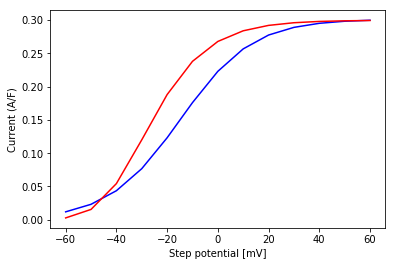

In [6]:
V = SSA_data[:,0]
I = SSA_data[:,1]
plt.figure()
plt.plot(V,I,'b-')
plt.plot(V,model_I,'r-')
plt.xlabel('Step potential [mV]')
plt.ylabel('Current (A/F)')

In [7]:
def cost(P,data,duration):
    
    outs = Activation(P,data,duration)
    model_peaks = outs['I_peak']
       
    dev_vector = model_peaks - I
    error = np.linalg.norm(dev_vector,2)
        
    return error


In [8]:
[P_opt, f_opt, iters, funcalls, warnflag] = opt.fmin(cost, init_params, args=(SSA_data,step_length),
                                                    maxiter = 200, maxfun = 200, full_output=True, disp=True)


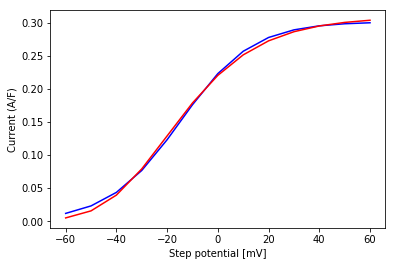

In [9]:
dats2 = Activation(P_opt,SSA_data,step_length)
model_I = dats2['I_peak']
plt.figure()
plt.plot(V,I,'b-')
plt.plot(V,model_I,'r-')
plt.xlabel('Step potential [mV]')
plt.ylabel('Current (A/F)')